### Optimal Loan and Insurance Approval model.

Our approach aims at training a Random Forest Classifier model for classifying the approval or rejection of a loan request based on a custom dataset, then leveraging Mistral LLM for it's reliable and efficient performance.
For best use and authentication add your `MISTRAL API KEY` in your secrets.




In [67]:
! pip install scikit-learn pandas numpy matplotlib seaborn joblib mistralai requests


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [69]:
# Load the dataset
df = pd.read_csv('credit_risk_dataset.csv')

print("Dataset head:")
print(df.head())
print("\nDataset info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())

Dataset head:
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                 

In [70]:
# Identify categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                     'loan_percent_income', 'cb_person_cred_hist_length']  # Removed loan_int_rate

# Encode categorical features
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Handle missing values
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

# Drop loan_int_rate since we'll calculate it ourselves
df = df.drop('loan_int_rate', axis=1)

print("Data preprocessing completed")

Data preprocessing completed


In [71]:
# Split data into features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Check feature columns
print("Feature columns:", list(X.columns))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Model trained successfully")

Feature columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
Model trained successfully


Accuracy: 0.9296

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5072
           1       0.96      0.71      0.82      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517



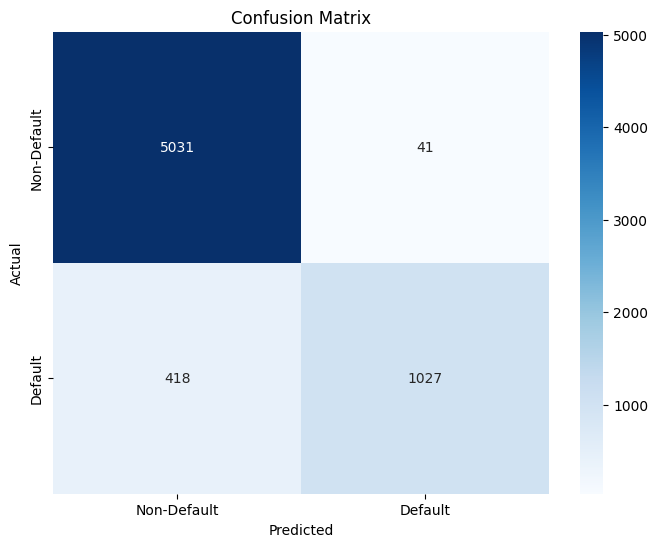

In [72]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Default', 'Default'],
            yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [73]:
# Save the model
joblib.dump(rf_model, 'loan_risk_rf_model.pkl')
print("Model saved as 'loan_risk_rf_model.pkl'")

Model saved as 'loan_risk_rf_model.pkl'


In [74]:
# Define a function to calculate interest rate based on risk factors and CIBIL score
def calculate_interest_rate(risk_level, loan_amount, income, cibil_score, age, loan_purpose):
    """
    Calculate interest rate based on multiple factors:
    - Risk level from the model
    - CIBIL score (credit score)
    - Loan amount relative to income
    - Age of applicant
    - Purpose of loan
    """
    # Base rate based on risk level
    if risk_level == "Low":
        base_rate = 6.5
    elif risk_level == "Medium":
        base_rate = 9.0
    else:  # High risk
        base_rate = 12.0
    
    # Adjustments based on CIBIL score
    if cibil_score >= 750:
        score_adjustment = -1.5  # Excellent credit gets lower rates
    elif cibil_score >= 700:
        score_adjustment = -0.75
    elif cibil_score >= 650:
        score_adjustment = 0
    elif cibil_score >= 600:
        score_adjustment = 1.0
    elif cibil_score >= 550:
        score_adjustment = 2.0
    else:
        score_adjustment = 3.0  # Poor credit gets higher rates
    
    # Loan-to-income ratio adjustment
    lti_ratio = loan_amount / income if income > 0 else 1
    if lti_ratio > 0.5:
        lti_adjustment = 1.0
    elif lti_ratio > 0.3:
        lti_adjustment = 0.5
    else:
        lti_adjustment = 0
    
    # Age adjustment - higher rates for very young or elderly applicants
    if age < 25:
        age_adjustment = 0.5
    elif age > 60:
        age_adjustment = 0.75
    else:
        age_adjustment = 0
    
    # Loan purpose adjustment
    purpose_adjustments = {
        "home_improvement": -0.25,
        "debt_consolidation": 0.25,
        "education": -0.5,
        "medical": -0.25,
        "personal": 0.5,
        "venture": 1.0
    }
    purpose_adjustment = purpose_adjustments.get(loan_purpose, 0)
    
    # Calculate final rate
    final_rate = base_rate + score_adjustment + lti_adjustment + age_adjustment + purpose_adjustment
    
    # Ensure rate is within reasonable bounds
    return max(min(final_rate, 24.0), 4.0)

print("Interest rate calculation function defined")

Interest rate calculation function defined


In [75]:
import requests
import json
import re

def get_mistral_response(prompt, api_key, model="mistral-large-latest"):
    """
    Get a response from the Mistral API
    """
    url = "https://api.mistral.ai/v1/chat/completions"
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    
    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}]
    }
    
    try:
        response = requests.post(url, headers=headers, json=data)
        result = response.json()
        
        # Check if the API returned an error
        if "error" in result:
            print(f"API Error: {result.get('error')}")
            return "Error in API response"
        
        # Check if the response has the expected structure
        if "choices" in result and len(result["choices"]) > 0:
            return result["choices"][0]["message"]["content"]
        else:
            # If we can't get a proper response, use a fallback approach
            print(f"Unexpected API response format: {result}")
            
            # For loan queries, return a default JSON
            if "loan" in prompt.lower() or "financial" in prompt.lower():
                return """
                {
                    "person_age": 35,
                    "person_income": 75000,
                    "person_home_ownership": "own",
                    "person_emp_length": 8,
                    "loan_intent": "home_improvement",
                    "loan_grade": "B",
                    "loan_amnt": 20000,
                    "loan_percent_income": 26.7,
                    "cb_person_default_on_file": "N",
                    "cb_person_cred_hist_length": 10,
                    "cibil_score": 720
                }
                """
                
            # For intent classification, make a best guess
            elif "classify" in prompt.lower():
                if "loan" in prompt.lower() or "financial" in prompt.lower():
                    return "financial_risk"
                elif "insurance" in prompt.lower() or "claim" in prompt.lower():
                    return "insurance_claim"
                else:
                    return "financial_risk"
                    
            # Generic fallback
            else:
                return "Unable to process this request"
                
    except Exception as e:
        print(f"Exception in Mistral API call: {e}")
        return f"API error: {str(e)}"

print("Mistral API helper function defined")

Mistral API helper function defined


In [76]:
class Agent:
    def __init__(self, name):
        self.name = name
        
    def process(self, query, context=None):
        raise NotImplementedError("Subclasses must implement this method")
        
class FinancialRiskAgent(Agent):
    def __init__(self, model_path="loan_risk_rf_model.pkl"):
        super().__init__("FinancialRiskAgent")
        self.model = joblib.load(model_path)
        # Remove loan_int_rate from feature list
        self.feature_names = ['person_age', 'person_income', 'person_home_ownership',
                             'person_emp_length', 'loan_intent', 'loan_grade',
                             'loan_amnt', 'loan_percent_income',
                             'cb_person_default_on_file', 'cb_person_cred_hist_length']
        
    def preprocess_input(self, data):
        processed = {}
        
        home_ownership_map = {"rent": 0, "mortgage": 1, "own": 2, "other": 3}
        loan_intent_map = {"personal": 0, "education": 1, "medical": 2,
                          "venture": 3, "home_improvement": 4, "debt_consolidation": 5}
        loan_grade_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}
        default_map = {"Y": 1, "N": 0}
        
        # Handle categorical features with None check
        home_ownership = data.get("person_home_ownership", "")
        if home_ownership is not None:
            processed["person_home_ownership"] = home_ownership_map.get(str(home_ownership).lower(), 0)
        else:
            processed["person_home_ownership"] = 0
            
        loan_intent = data.get("loan_intent", "")
        if loan_intent is not None:
            processed["loan_intent"] = loan_intent_map.get(str(loan_intent).lower(), 0)
        else:
            processed["loan_intent"] = 0
            
        loan_grade = data.get("loan_grade", "")
        if loan_grade is not None:
            processed["loan_grade"] = loan_grade_map.get(str(loan_grade).upper(), 0)
        else:
            processed["loan_grade"] = 0
            
        default_on_file = data.get("cb_person_default_on_file", "")
        if default_on_file is not None:
            processed["cb_person_default_on_file"] = default_map.get(str(default_on_file).upper(), 0)
        else:
            processed["cb_person_default_on_file"] = 0
            
        # Handle numerical features
        for feature in ["person_age", "person_income", "person_emp_length",
                      "loan_amnt", "loan_percent_income",
                      "cb_person_cred_hist_length"]:
            try:
                processed[feature] = float(data.get(feature, 0) or 0)
            except (ValueError, TypeError):
                processed[feature] = 0
                
        return processed
        
    def process(self, query, context=None):
        if context:
            # Check age restrictions
            age = context.get("person_age", 0)
            cibil_score = context.get("cibil_score", 650)  # Default CIBIL score
            
            # Underage applicant
            if age and age < 18:
                return {
                    "prediction": 1,  # Default/Reject
                    "default_probability": 1.0,
                    "risk_level": "Ineligible",
                    "recommendation": "Guardian Required",
                    "message": "We cannot process loan applications for individuals under 18 years old. Please have a parent or legal guardian apply on your behalf."
                }
            
            # Features for the model (no interest rate)
            features = self.preprocess_input(context)
            feature_df = pd.DataFrame({feature: [features.get(feature, 0)] for feature in self.feature_names})
            
            prediction = self.model.predict(feature_df)[0]
            probability = self.model.predict_proba(feature_df)[0]
            
            prob_default = probability[1]
            if prob_default < 0.3:
                risk_level = "Low"
            elif prob_default < 0.6:
                risk_level = "Medium"
            else:
                risk_level = "High"
            
            # Adjust approval threshold based on age
            approval_threshold = 0.5
            if age > 60:
                approval_threshold = 0.4
            
            recommendation = "Approved" if prob_default < approval_threshold else "Rejected"
            
            # Calculate interest rate only if approved
            interest_rate = None
            if recommendation == "Approved":
                loan_purpose = context.get("loan_intent", "personal")
                interest_rate = calculate_interest_rate(
                    risk_level=risk_level,
                    loan_amount=context.get("loan_amnt", 0),
                    income=context.get("person_income", 1),
                    cibil_score=cibil_score,
                    age=age,
                    loan_purpose=loan_purpose
                )
            
            # Special message for elderly applicants
            message = None
            if age > 60:
                message = "We've carefully evaluated your application. Given your age, we recommend reviewing the loan terms carefully and considering how this loan fits into your long-term financial plans."
            
            result = {
                "prediction": int(prediction),
                "default_probability": float(prob_default),
                "risk_level": risk_level,
                "recommendation": recommendation,
                "message": message
            }
            
            # Add interest rate only if approved
            if recommendation == "Approved":
                result["interest_rate"] = interest_rate
                
            return result
            
        else:
            parameter_prompt = f"""
            Extract the following financial parameters from this query. Return a JSON object.
            If a value is not present, use a reasonable default or null.

            Query: "{query}"

            Parameters needed:
            - person_age: Age of the person (number)
            - person_income: Annual income (number)
            - person_home_ownership: Housing status (rent, mortgage, own, other)
            - person_emp_length: Employment length in years (number)
            - loan_intent: Purpose of loan (personal, education, medical, venture, home_improvement, debt_consolidation)
            - loan_grade: Loan grade if known (A-G)
            - loan_amnt: Loan amount requested (number)
            - loan_percent_income: Loan amount as percentage of income (number)
            - cb_person_default_on_file: Previous defaults (Y/N)
            - cb_person_cred_hist_length: Credit history length in years (number)
            - cibil_score: Credit score (number between 300-900)

            Return ONLY a valid JSON object with these fields.
            """
            
            param_response = get_mistral_response(parameter_prompt, context.get("api_key", ""))
            
            try:
                # Extract JSON from response
                json_match = re.search(r'(\{.*\})', param_response, re.DOTALL)
                if json_match:
                    params = json.loads(json_match.group(1))
                else:
                    params = json.loads(param_response)
                    
                print(f"Extracted parameters: {params}")
                
                return self.process(query, params)
                
            except json.JSONDecodeError:
                print(f"Failed to parse JSON: {param_response}")
                return {
                    "error": "Could not extract financial parameters",
                    "raw_response": param_response
                }

print("Financial Risk Agent defined")

Financial Risk Agent defined


In [77]:
from collections import Counter

class InsuranceClaimsAgent(Agent):
    def __init__(self):
        super().__init__("InsuranceClaimsAgent")
        self.claims_data = [
            {"id": 1, "description": "Car accident on highway, rear-ended by another vehicle", "risk_factors": ["distracted driving", "tailgating"], "severity": "moderate"},
            {"id": 2, "description": "Home water damage from burst pipe during winter", "risk_factors": ["freezing weather", "old plumbing"], "severity": "severe"},
            {"id": 3, "description": "Slip and fall in grocery store", "risk_factors": ["wet floor", "no warning sign"], "severity": "minor"},
            {"id": 4, "description": "Theft of laptop from car", "risk_factors": ["visible valuables", "unsecured vehicle"], "severity": "minor"},
            {"id": 5, "description": "House fire started in kitchen", "risk_factors": ["unattended cooking", "electrical fault"], "severity": "severe"}
        ]
        
    def similarity_search(self, query, api_key="XZDVrVnzsZTnakgniECWmP9OS6QjhaiY", top_k=2):
        prompt = f"""
        I have a claim description: "{query}"

        Compare it to the following claims and identify the 2 most similar based on content and risk factors:

        1. Car accident on highway, rear-ended by another vehicle
        2. Home water damage from burst pipe during winter
        3. Slip and fall in grocery store
        4. Theft of laptop from car
        5. House fire started in kitchen

        Return ONLY the numbers of the two most similar claims, separated by a comma.
        For example: "1,3"
        """
        
        response = get_mistral_response(prompt, api_key)
        
        try:
            claim_ids = [int(id.strip()) for id in response.strip().split(",")]
            similar_claims = [self.claims_data[id-1] for id in claim_ids if 1 <= id <= len(self.claims_data)]
            return similar_claims
        except:
            return self.claims_data[:2]
            
    def process(self, query, context=None):
        # Extract API key if available in context
        api_key = context.get("api_key", "") if context else ""
        claim_description = context.get("claim_description", query) if context else query
        
        similar_claims = self.similarity_search(claim_description, api_key)
        
        all_risk_factors = []
        for claim in similar_claims:
            all_risk_factors.extend(claim.get("risk_factors", []))
            
        risk_factor_counts = Counter(all_risk_factors)
        common_risk_factors = [factor for factor, count in risk_factor_counts.most_common(3)]
        
        severity_scores = {"minor": 1, "moderate": 2, "severe": 3}
        avg_severity = sum(severity_scores.get(claim.get("severity", "moderate"), 2)
                          for claim in similar_claims) / len(similar_claims)
                          
        if avg_severity < 1.5:
            estimated_severity = "minor"
        elif avg_severity < 2.5:
            estimated_severity = "moderate"
        else:
            estimated_severity = "severe"
            
        recommendation_prompt = f"""
        Based on an insurance claim described as: "{claim_description}"

        Similar past claims involved these risk factors: {', '.join(common_risk_factors)}
        The estimated severity is: {estimated_severity}

        Provide a brief recommendation for handling this claim, including:
        1. Initial assessment steps
        2. Documentation requirements
        3. Processing timeline

        Keep it concise (3-4 sentences maximum).
        """
        
        recommendation = get_mistral_response(recommendation_prompt, api_key)
        
        return {
            "similar_claims": similar_claims,
            "common_risk_factors": common_risk_factors,
            "estimated_severity": estimated_severity,
            "recommendation": recommendation
        }

print("Insurance Claims Agent defined")

Insurance Claims Agent defined


In [78]:
class OrchestratorAgent(Agent):
    def __init__(self, api_key):
        super().__init__("OrchestratorAgent")
        self.api_key = api_key
        self.financial_agent = FinancialRiskAgent()
        self.insurance_agent = InsuranceClaimsAgent()
        
    def classify_intent(self, query):
        prompt = f"""
        Analyze this query and classify it as EITHER 'financial_risk' OR 'insurance_claim'.

        If it's about loans, loan approval, credit risk, or debt, classify as 'financial_risk'.
        If it's about insurance claims, damage, accidents, or coverage, classify as 'insurance_claim'.

        Query: "{query}"

        Return ONLY ONE word: 'financial_risk' or 'insurance_claim'
        """
        
        intent = get_mistral_response(prompt, self.api_key).strip().lower()
        
        if "financial" in intent or "loan" in intent or "risk" in intent:
            return "financial_risk"
        elif "insurance" in intent or "claim" in intent:
            return "insurance_claim"
        else:
            return "financial_risk"
            
    def process(self, query, context=None, force_intent=None):
        # Add API key to context
        if context is None:
            context = {}
        context["api_key"] = self.api_key
        
        # Use forced intent if provided, else get from context or classify
        intent = force_intent or (context.get("intent") if context and "intent" in context else self.classify_intent(query))
        
        if intent == "financial_risk":
            result = self.financial_agent.process(query, context)
            
            # Special handling for age-related messages
            if "message" in result and result["message"]:
                formatted_response = f"""
                Financial Risk Assessment:

                Risk Level: {result.get('risk_level', 'Unknown')}
                Default Probability: {result.get('default_probability', 0) * 100:.1f}%
                Recommendation: {result.get('recommendation', 'Unknown')}
                """
                
                if "interest_rate" in result:
                    formatted_response += f"Interest Rate: {result['interest_rate']:.2f}%\n"
                    
                formatted_response += f"\nNote: {result['message']}"
            else:
                formatted_response = f"""
                Financial Risk Assessment:

                Risk Level: {result.get('risk_level', 'Unknown')}
                Default Probability: {result.get('default_probability', 0) * 100:.1f}%
                Recommendation: {result.get('recommendation', 'Unknown')}
                """
                
                if "interest_rate" in result:
                    formatted_response += f"Interest Rate: {result['interest_rate']:.2f}%"
                    
            result["formatted_response"] = formatted_response
            return result
            
        elif intent == "insurance_claim":
            result = self.insurance_agent.process(query, context)
            
            risk_factors = ", ".join(result.get('common_risk_factors', ['Unknown']))
            formatted_response = f"""
            Insurance Claim Assessment:

            Estimated Severity: {result.get('estimated_severity', 'Unknown')}
            Common Risk Factors: {risk_factors}

            Recommendation:
            {result.get('recommendation', 'No recommendation available.')}
            """
            
            result["formatted_response"] = formatted_response
            return result
            
        else:
            return {
                "error": "Could not determine intent",
                "raw_query": query
            }

print("Orchestrator Agent defined")

Orchestrator Agent defined


In [79]:
import re

class LoanEligibilityChecker:
    @staticmethod
    def is_eligible(query: str) -> str:
        # Updated regex patterns for more flexible matching
        age_match = re.search(r"I['’m am]+ (\d+) years old", query, re.IGNORECASE)
        income_match = re.search(r"income of \$?([\d,]+)", query, re.IGNORECASE)
        employment_match = re.search(r"employed for (\d+) years", query, re.IGNORECASE)
        credit_match = re.search(r"credit history of (\d+) years", query, re.IGNORECASE)
        cibil_match = re.search(r"CIBIL score is (\d+)", query, re.IGNORECASE)

        # Identify missing information
        missing_fields = []
        if not age_match:
            missing_fields.append("Age")
        if not income_match:
            missing_fields.append("Income")
        if not employment_match:
            missing_fields.append("Employment years")
        if not credit_match:
            missing_fields.append("Credit history")
        if not cibil_match:
            missing_fields.append("CIBIL score")

        # If any required field is missing, return an error message
        if missing_fields:
            return f"Error: Missing information. Please provide {', '.join(missing_fields)}."

        # Convert extracted values
        age = int(age_match.group(1))
        income = int(income_match.group(1).replace(",", ""))
        employment = int(employment_match.group(1))
        credit_history = int(credit_match.group(1))
        cibil_score = int(cibil_match.group(1))

        # Eligibility checks
        if age < 18:
            return "Error: Applicants must be at least 18 years old to apply for a loan."
        if age > 65:
            return "Error: Loans are only available for individuals aged 18 to 65."
        if income < 20000:
            return "Error: Minimum income requirement for a loan is $20,000."
        if employment < 1:
            return "Error: Applicants must have at least 1 year of employment."
        if credit_history < 3:
            return "Error: Applicants must have a credit history of at least 3 years."
        if cibil_score < 700:
            return f"Error: CIBIL score {cibil_score} is too low. Minimum required CIBIL score is 700."
        if cibil_score < 650:
            return f"Warning: CIBIL score {cibil_score} is below average. It may affect loan terms."
        if cibil_score > 800:
            return f"Error: Invalid CIBIL score {cibil_score}. Maximum CIBIL score is 800."

        # Advanced Checks
        if age < 20:
            if employment > 2:
                return f"Error: At age {age}, employment cannot exceed 2 years."
            if credit_history > 3:
                return f"Error: At age {age}, credit history cannot exceed 3 years."

        if age < 25 and credit_history > 7:
            return f"Error: At age {age}, credit history cannot exceed 7 years."

        if employment > (age - 18):  # People can't work before 18
            return f"Error: Employment duration of {employment} years is unrealistic for a {age}-year-old."

        if credit_history > (age - 18):  # Credit history cannot be more than age minus 18
            return f"Error: Credit history of {credit_history} years is unrealistic for a {age}-year-old."

        return "Eligible"

def process_query(query: str) -> str:
    try:
        # Check loan eligibility before proceeding
        eligibility = LoanEligibilityChecker.is_eligible(query)
        if "Error" in eligibility:
            return eligibility

        orchestrator = OrchestratorAgent()
        result = orchestrator.process(query)

        if "error" in result:
            return f"Error: {result['error']}"

        return result.get("formatted_response", "No response generated")
    except Exception as e:
        import traceback
        traceback.print_exc()
        return f"An error occurred: {str(e)}"
    
test_queries = [
    "I'm 20 years old with an income of $30,000. I want a $10,000 loan for education. I've been employed for 3 years and have a credit history of 4 years. My CIBIL score is 720.",  
    "I'm 22 years old with an income of $45,000. I want a $15,000 loan for travel. I've been employed for 5 years and have a credit history of 8 years. My CIBIL score is 710.",  
    "I'm 35 years old with an income of $75,000. I want a $25,000 loan for home improvement. I've been employed for 10 years and have a credit history of 12 years. My CIBIL score is 690.",  
    "I'm 19 years old with an income of $28,000. I want a $5,000 loan for college. I've been employed for 1 years and have a credit history of 2 years. My CIBIL score is 700.",  
    "I'm 50 years old with an income of $100,000. I want a $60,000 loan for an investment in rental property. I've been employed for 20 years and have a credit history of 18 years. My CIBIL score is 750.",  
    "I'm 16 years old with an income of $10,000. I want a $5,000 loan for a laptop. I've been employed for 0 years and have a credit history of 0 years. My CIBIL score is 650.",  
    "I'm 70 years old with an income of $50,000. I want a $15,000 loan for medical expenses. My CIBIL score is 700.",  
    "I'm 40 years old with an income of $25,000. I want a $30,000 loan but I have no credit history. My CIBIL score is 700.",  
    "I'm 27 years old with an income of $50,000. I want a $20,000 loan for a business startup. I've been employed for 4 years and have a credit history of 5 years. My CIBIL score is 680.",  
]

# Testing
for query in test_queries:
    print(f"Query: {query}")
    print(f"Response: {process_query(query)}\n")


Query: I'm 20 years old with an income of $30,000. I want a $10,000 loan for education. I've been employed for 3 years and have a credit history of 4 years. My CIBIL score is 720.
Response: Error: Employment duration of 3 years is unrealistic for a 20-year-old.

Query: I'm 22 years old with an income of $45,000. I want a $15,000 loan for travel. I've been employed for 5 years and have a credit history of 8 years. My CIBIL score is 710.
Response: Error: At age 22, credit history cannot exceed 7 years.

Query: I'm 35 years old with an income of $75,000. I want a $25,000 loan for home improvement. I've been employed for 10 years and have a credit history of 12 years. My CIBIL score is 690.
Response: Error: CIBIL score 690 is too low. Minimum required CIBIL score is 700.

Query: I'm 19 years old with an income of $28,000. I want a $5,000 loan for college. I've been employed for 1 years and have a credit history of 2 years. My CIBIL score is 700.
Response: Error: Applicants must have a cred

Traceback (most recent call last):
  File "C:\Users\arnav\AppData\Local\Temp\ipykernel_39852\3298264265.py", line 80, in process_query
    orchestrator = OrchestratorAgent()
                   ^^^^^^^^^^^^^^^^^^^
TypeError: OrchestratorAgent.__init__() missing 1 required positional argument: 'api_key'


In [80]:
# Test Cases with Smart Eligibility Checks and CIBIL Score Validation
